In [82]:
import matplotlib.pyplot as plt
import numpy as np
from keras.api.models import load_model
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import librosa
import os
from pathlib import Path
import itertools
from sklearn.metrics import auc, classification_report, roc_curve

# Directories
DATA_DIR = "../data"
AUDIOS_DIR = DATA_DIR + "/audios"
POS_AUDIOS_DIR = AUDIOS_DIR + "/positive"
NEG_AUDIOS_DIR = AUDIOS_DIR + "/negative"
MODELS_DIR = "../models"

In [129]:
ARCHITECTURE = "lstm" # ff, cnn, lstm
FEATURE = "chroma" # mfcc, lfcc, chroma

directorio = Path(MODELS_DIR)
prefijo = ARCHITECTURE+"_"+FEATURE
MODEL = next(directorio.glob(f'{prefijo}*'))
print(MODEL)

..\models\lstm_chroma_0.2633.keras


### Data collector

In [130]:
with open(f"{DATA_DIR}/{FEATURE}.pkl", "rb") as f:
    data = pickle.load(f)

# Positive data
positive_data = np.array(data["positive"])
positive_labels = np.ones(positive_data.shape[0])
pnames = data["pnames"]

# Negative data
negative_data = np.array(data["negative"])
negative_labels = np.zeros(negative_data.shape[0])
nnames = data["nnames"]

# Concatenate the data
X = np.concatenate((positive_data, negative_data), axis=0)
y = np.concatenate((positive_labels, negative_labels), axis=0)
names = np.concatenate((pnames, nnames), axis=0)

# Establecer la semilla aleatoria
seed = 1  # Elige cualquier número entero como semilla
rng = np.random.default_rng(seed)

# Shuffle the data using the random number generator
idx = rng.permutation(len(X))

X = X[idx]
y = y[idx]
names = names[idx]

# Funciones auxiliares
def normalize(X):
    return (X - np.mean(X)) / np.std(X)


def sub_extra_column(X):
    return X[:, :, :-1]


def transpose(X):
    return X.transpose(0, 2, 1)


# Definición del pipeline
preprocessing_pipeline = Pipeline(
    [
        ("normalize", FunctionTransformer(normalize, validate=False)),  # Normalización
        ("scale", MinMaxScaler(feature_range=(0, 1))),  # Escalado
        (
            "sub_column",
            FunctionTransformer(sub_extra_column, validate=False),
        ),  # Quitar columna
        ("transpose", FunctionTransformer(transpose, validate=False)),  # Transponer
    ]
)


# Aplicar el pipeline
def process_and_encode(X):
    # Reshape para MinMaxScaler (flatten y restaurar)
    X = preprocessing_pipeline.named_steps["normalize"].transform(X)
    X = (
        preprocessing_pipeline.named_steps["scale"]
        .fit_transform(X.reshape(X.shape[0], -1))
        .reshape(X.shape)
    )
    X = preprocessing_pipeline.named_steps["sub_column"].transform(X)
    X = preprocessing_pipeline.named_steps["transpose"].transform(X)

    # Predicción con el encoder
    encoder = load_model(f"{MODELS_DIR}/encoders/encoder_{FEATURE}.keras")
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    XC = encoder.predict(X)
    return XC


X = process_and_encode(X)

percent = 1
trn_size = 0.8
tst_size = 1 - trn_size

X_train, X_tst, y_train, y_tst, idxtrn, idxtst = train_test_split(
    X,
    y,
    np.arange(len(X)),
    train_size=trn_size * percent,
    test_size=tst_size * percent,
    stratify=y,
    random_state=seed,
)

# Mantain the names of the audios
names = np.array(names)
namestrn = names[idxtrn]
namestst = names[idxtst]

print(X_train.shape)
print(y_train.shape)
print(X_tst.shape)
print(y_tst.shape)


c:\Users\angel\anaconda3\envs\TFG\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(8000, 78, 12, 1)
(8000,)
(2000, 78, 12, 1)
(2000,)


# Evaluation

Loading model:  ..\models\lstm_chroma_0.2633.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

    Negative       0.97      0.81      0.88      1000
    Positive       0.83      0.97      0.90      1000

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000

[[805 195]
 [ 26 974]]
AUC: 0.8895


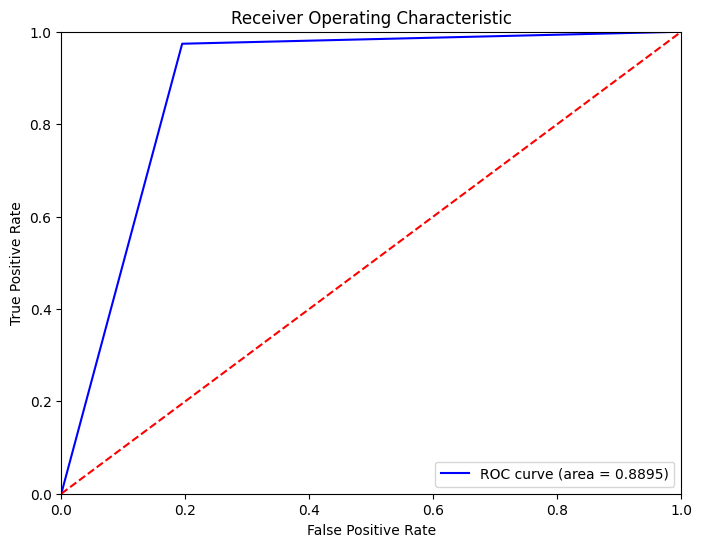

Normalized confusion matrix


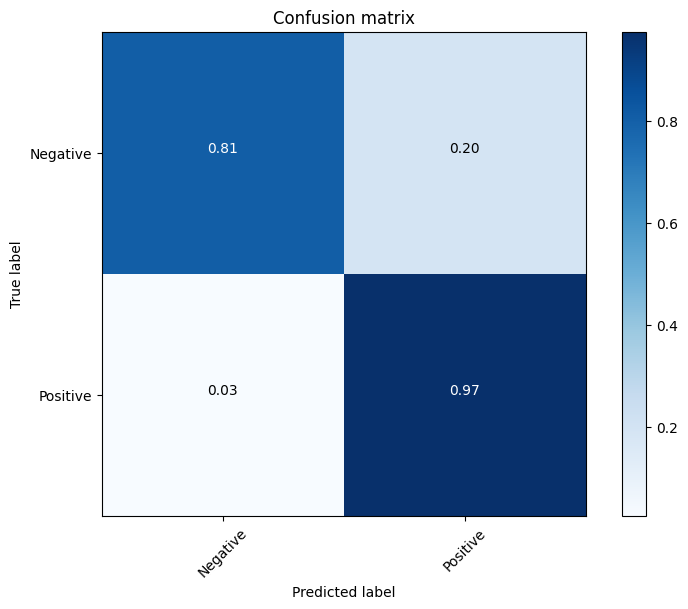

In [131]:
# Getting metrics such as accuracy, precision, recall, f1-score, confusion matrix, ROC and AUC
print("Loading model: ", MODEL)
model = load_model(f"{MODELS_DIR}/{MODEL}")

# Predict the test set
y_pred = model.predict(X_tst)
y_pred = (y_pred > 0.5).astype(int)
y_pred = y_pred.flatten()

# Classification report
print(classification_report(y_tst, y_pred, target_names=["Negative", "Positive"]))
# Confusion matrix
cm = confusion_matrix(y_tst, y_pred)
print(cm)


# Plot confusion matrix
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_tst, y_pred)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(
    cm, classes=["Negative", "Positive"], normalize=True, title="Confusion matrix"
)
plt.show()


In [132]:
# Reproducir audio con mayor tasa de error

# Obtener los índices de los audios con mayor tasa de error de los audios
# de prueba negativos
type = 0
best = 1
idxtst_type = np.where(y_tst == type)[0]

if type == 1:
    amount = 83
else:
    amount = 15

amount = 1000

model = load_model(f"{MODELS_DIR}/{MODEL}")

y_pred = model.predict(X_tst[idxtst_type])
y_pred = y_pred.flatten()

diff = np.abs(y_pred - y_tst[y_tst == type])

idx = np.argsort(diff)
if best == 0:
    idx = idx[::-1]

# Show names of the audios with higher error rate
names = []
predictions = []
for i in range(amount):
    names.append(namestst[idxtst_type][idx[i]])
    print(
        f"Audio: {namestst[idxtst_type][idx[i]]}, Predicted: {y_pred[idx[i]]}, True: {y_tst[y_tst == type][idx[i]]}"
    )
    predictions.append(y_pred[idx[i]])


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Audio: 0-Silence-G81uH2Cu_eY.wav, Predicted: 0.0006298774969764054, True: 0.0
Audio: 0-Thunderstorm-Jh-upSoOqTc.wav, Predicted: 0.0006854583043605089, True: 0.0
Audio: 0-Thunderstorm-SdHsbNDd_zA.wav, Predicted: 0.0006960086757317185, True: 0.0
Audio: 0-Thunder-CWwyiIC2Y3w.wav, Predicted: 0.000700676697306335, True: 0.0
Audio: 0-Drill--nBE4nJr3aM.wav, Predicted: 0.0007027428364381194, True: 0.0
Audio: 0-Rain-YhLgb_mzFbs.wav, Predicted: 0.0007088411366567016, True: 0.0
Audio: 0-Bark-EakI8v4Ztt4.wav, Predicted: 0.0007169898017309606, True: 0.0
Audio: 0-Rain-0FDWsTXC620.wav, Predicted: 0.0007217664388008416, True: 0.0
Audio: 0-Walk,_footsteps--Q7dmNjHyyI.wav, Predicted: 0.0007223382126539946, True: 0.0
Audio: 0-Thunderstorm-t_zbXrKUDEE.wav, Predicted: 0.0007364826160483062, True: 0.0
Audio: 0-Rain-0XzGZXpgfFg.wav, Predicted: 0.0007460969500243664, True: 0.0
Audio: 0-Rain--tGz_5sDpoY.wav, Predicted: 0.0007501745712943375, True: 0.0
Audio: 0-Walk,_foot

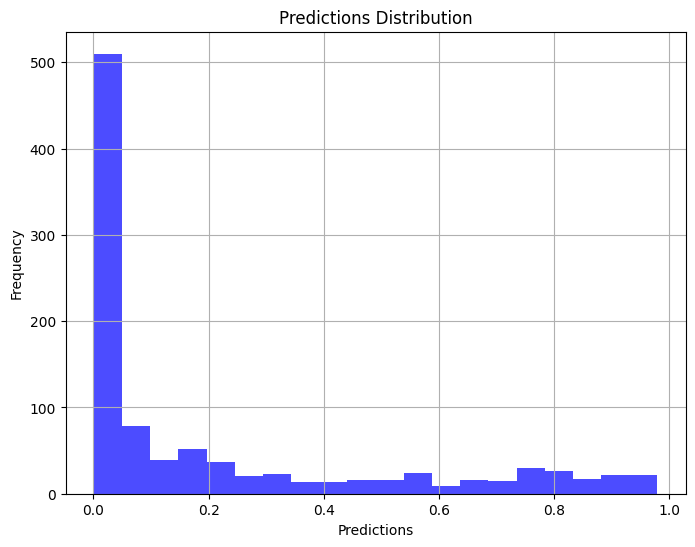

In [133]:
# Plot y_pred distribution in bar plot in log10 scale

# Invert the predictions to show the negative ones
predictions = [p for p in predictions]

plt.figure(figsize=(8, 6))
plt.hist(predictions, bins=20, color="blue", alpha=0.7)
plt.title("Predictions Distribution")
plt.xlabel("Predictions")
plt.ylabel("Frequency")
plt.grid()
plt.show()


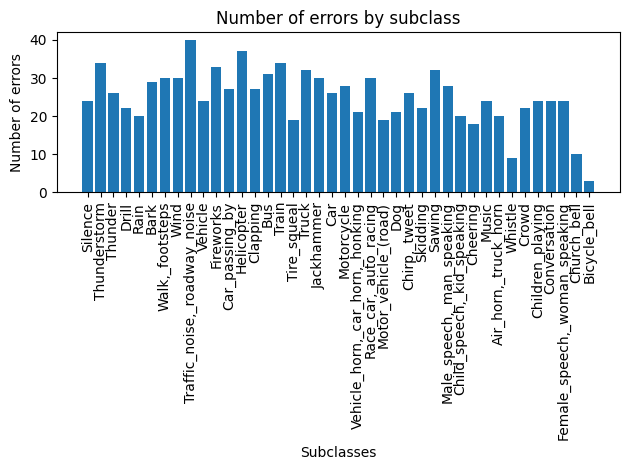

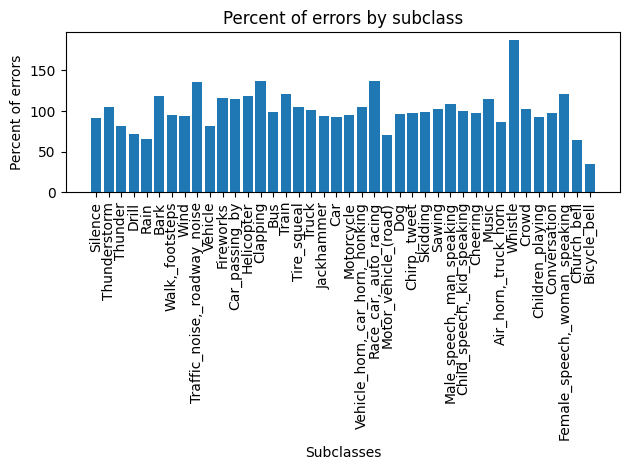

In [134]:
# Plotear de cada subclase cuantos fallos ha habido
subclases = {}
for name in names:
    # Extraer la subclase del nombre del audio
    subclase = name.split("-")[1]
    if subclase not in subclases:
        subclases[subclase] = 0
    subclases[subclase] += 1


# Sort subclasses alphabetically
if type == 0:
    percents = {
        "Air_horn,_truck_horn": 0.0232,
        "Bark": 0.0246,
        "Bicycle_bell": 0.0086,
        "Bus": 0.031199999999999995,
        "Car": 0.028000000000000004,
        "Car_passing_by": 0.0236,
        "Cheering": 0.0184,
        "Child_speech,_kid_speaking": 0.02,
        "Children_playing": 0.026000000000000002,
        "Chirp,_tweet": 0.0268,
        "Church_bell": 0.015599999999999998,
        "Clapping": 0.0198,
        "Conversation": 0.0246,
        "Crowd": 0.021399999999999995,
        "Dog": 0.0218,
        "Drill": 0.030600000000000002,
        "Female_speech,_woman_speaking": 0.0198,
        "Fireworks": 0.0284,
        "Helicopter": 0.031199999999999995,
        "Jackhammer": 0.0318,
        "Male_speech,_man_speaking": 0.0258,
        "Motor_vehicle_(road)": 0.0268,
        "Motorcycle": 0.0294,
        "Music": 0.0208,
        "Race_car,_auto_racing": 0.022,
        "Rain": 0.0304,
        "Sawing": 0.0314,
        "Silence": 0.0262,
        "Skidding": 0.022399999999999996,
        "Thunder": 0.032,
        "Thunderstorm": 0.0324,
        "Tire_squeal": 0.0182,
        "Traffic_noise,_roadway_noise": 0.0296,
        "Train": 0.028000000000000004,
        "Truck": 0.0316,
        "Vehicle": 0.0294,
        "Vehicle_horn,_car_horn,_honking": 0.02,
        "Walk,_footsteps": 0.0316,
        "Whistle": 0.0048,
        "Wind": 0.0318,
    }
    rot = 90
else:
    percents = {
        "Ambulance_(siren)": 0.0572,
        "Emergency_vehicle": 0.6398,
        "Fire_engine,_fire_truck_(siren)": 0.1352,
        "Police_car_(siren)": 0.1678,
    }
    rot = 20

# Bar plot
plt.bar(subclases.keys(), subclases.values())
plt.xlabel("Subclasses")
plt.ylabel("Number of errors")

plt.title("Number of errors by subclass")
plt.xticks(rotation=rot)
plt.tight_layout()
plt.show()

for i, subclase in enumerate(subclases.keys()):
    subclases[subclase] = subclases[subclase] / (1000 * percents[subclase]) * 100

# Bar plot
plt.bar(subclases.keys(), subclases.values())
plt.xlabel("Subclasses")
plt.ylabel("Percent of errors")

plt.title("Percent of errors by subclass")
plt.xticks(rotation=rot)
plt.tight_layout()
plt.show()



Reproduciendo audio: 0-Silence-G81uH2Cu_eY.wav


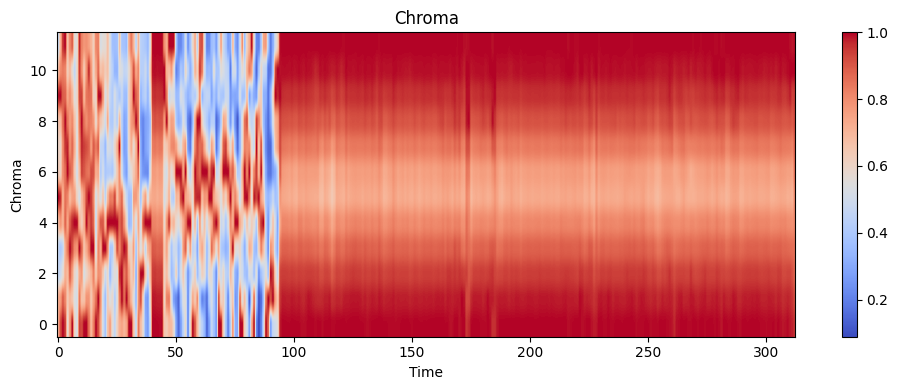

Audio: 0-Silence-G81uH2Cu_eY.wav


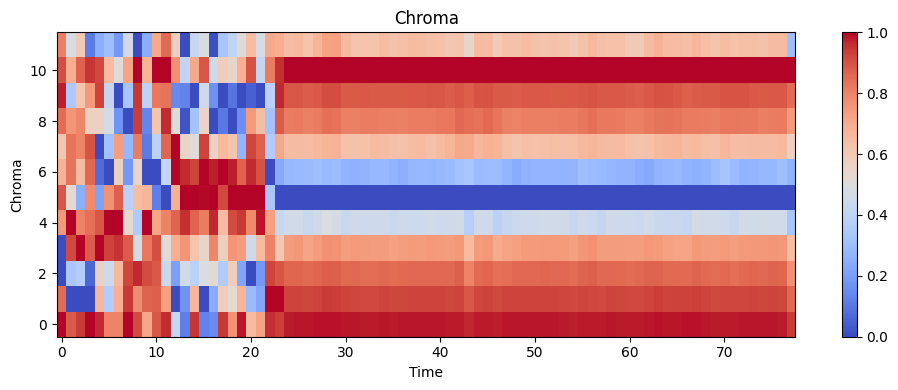

In [135]:
# Reproducir los audios con mayor tasa de error
chromas = []
if type == 1:
    dir = POS_AUDIOS_DIR
else:
    dir = NEG_AUDIOS_DIR
for i in range(1):
    audio_name = namestst[idxtst_type][idx[i]]
    audio_path = os.path.join(dir, audio_name)
    print(f"\nReproduciendo audio: {audio_name}")
    try:
        y, sr = librosa.load(audio_path, sr=16000)
        ipd.display(ipd.Audio(y, rate=sr))
    except FileNotFoundError:
        print(f"¡Error! No se encontró el archivo de audio en la ruta: {audio_path}")
    except Exception as e:
        print(f"Ocurrió un error al cargar el audio: {e}")

    # Cargar el chroma del audio
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Original version of the audio
# Plot chroma
plt.figure(figsize=(10, 4))
plt.title("Chroma")
plt.imshow(chroma, aspect="auto", origin="lower", cmap="coolwarm")
plt.xlabel("Time")
plt.ylabel("Chroma")
plt.colorbar()
plt.tight_layout()
plt.show()

# Process version of the audio
tst = X_tst[idxtst_type][idx[0]]
tst = tst.reshape(tst.shape[0], tst.shape[1] * tst.shape[2])
tst = tst.transpose(1, 0)
# Map to 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
tst = scaler.fit_transform(tst)
tst = 1 - tst
audio_name = namestst[idxtst_type][idx[0]]
print(f"Audio: {audio_name}")

# Plot chroma
plt.figure(figsize=(10, 4))
plt.title("Chroma")
plt.imshow(tst, aspect="auto", origin="lower", cmap="coolwarm")
plt.xlabel("Time")
plt.ylabel("Chroma")
plt.colorbar()
plt.tight_layout()
plt.show()

### Losses

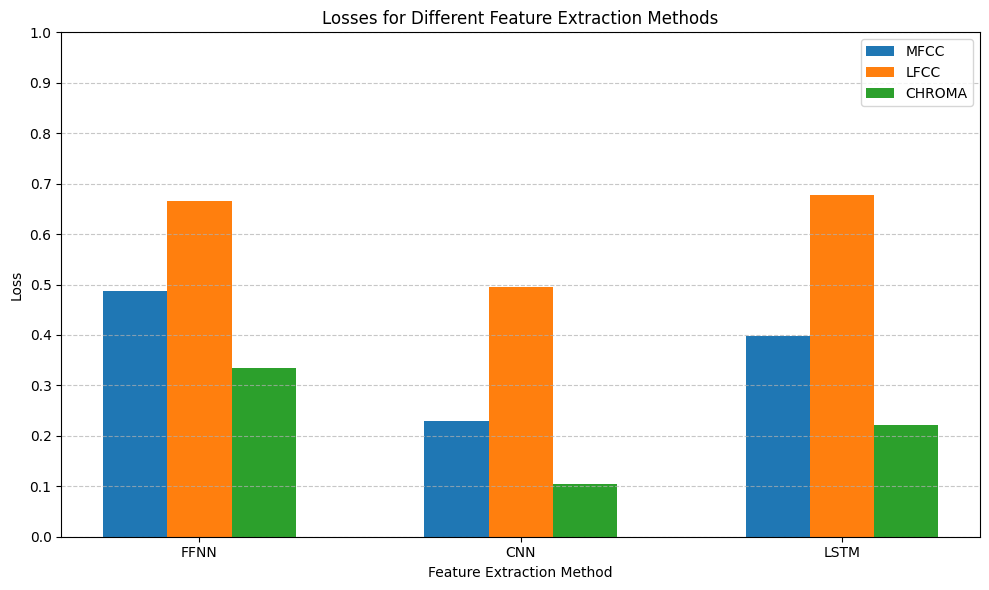

In [136]:
# Losses for each feature extraction method in 3 different models
mfcc = [0.4877, 0.2287, 0.3986]
lfcc = [0.6663, 0.4954, 0.6782]
chrm = [0.3339, 0.1037, 0.2224]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.title("Losses for Different Feature Extraction Methods")
plt.xlabel("Feature Extraction Method")
plt.ylabel("Loss")
plt.ylim(0, 1)

plt.xticks(np.arange(3), ["FFNN", "CNN", "LSTM"])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.bar(np.arange(3) - 0.2, mfcc, width=0.2, label="MFCC")
plt.bar(np.arange(3), lfcc, width=0.2, label="LFCC")
plt.bar(np.arange(3) + 0.2, chrm, width=0.2, label="CHROMA")
plt.legend()
plt.tight_layout()
plt.show()